In [99]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

import shap
from windowshap import StationaryWindowSHAP

# Set seeds for reproducibility
np.random.seed(7) # For NumPy
tf.random.set_seed(7) # For TensorFlow

In [100]:
## Step 0 : Setting (hyper)parameters and other variables

# Selecting the tickers and features to be used in the analysis
tickers_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
included_features = ['Open', 'Close', 'High', 'Low', 'Volume']

# Start and end dates, as well as window size as in (Chaudhary and Rajneesh, 2025)
sample_start_date = '2024-04-01'
sample_end_date = '2025-05-01'
window_size = 60

In [101]:
## Step 1 : Fetch and scale stock data using Yahoo Finance

# Download and store stock data (daily)
def get_stock_data(ticker):
    df = yf.download(ticker, start=sample_start_date, end=sample_end_date, group_by='column')
    return df[included_features]

print("Downloading and storing data...")
data_map = {ticker: get_stock_data(ticker) for ticker in tickers_list}

for ticker in tickers_list:
    df = data_map[ticker]

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None
    data_map[ticker] = df


# Normalize each ticker separately
print("Normalizing data...")

scalers = {}
scaled_data_map = {}

for ticker in tickers_list:
    df = data_map[ticker]

    # Define train split index — e.g., 80% of data
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size]
    scaler = MinMaxScaler()  # or RobustScaler()

    # Fit on train only
    scaler.fit(train_df)

    # Transform full series (using train-fitted scaler)
    scaled_array = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)

    scaled_data_map[ticker] = scaled_df
    scalers[ticker] = scaler

print("Data prep complete.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Normalizing data...
Data prep complete.


In [102]:
## Step 2 : Build and train LSTM models

# Build LSTM model

def build_model(n_input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=n_input_shape))
    model.add(Dropout(0.2)) 
    model.add(LSTM(32)) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')

    return model

# Build sequences
def build_sequences(df, window_size):
    X, y = [], []
    arr = df.values

    close_idx = df.columns.get_loc('Close')  

    for i in range(len(df) - window_size):
        X.append(arr[i:i + window_size])
        y.append(arr[i + window_size, close_idx])

    return np.array(X), np.array(y)

# Store models and SHAP values
models = {}
X_train_sets = {}
X_test_sets = {}
y_pred_sets = {}
y_test_sets = {}
eval_metrics = {}

for ticker in tickers_list:
    print(f'\nProcessing {ticker} :')

    df = scaled_data_map[ticker]
    
    split_idx = int(len(df) * 0.8) # 80/20 train/test split
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx - window_size:] # Including overlap for sequence creatinon (double check!)
    
    X_train, y_train = build_sequences(train_df, window_size)
    X_test, y_test = build_sequences(test_df, window_size)

    X_train_sets[ticker] = X_train
    X_test_sets[ticker] = X_test
    
    # Training model
    print('Building and training...')
    model = build_model(n_input_shape=(window_size, X_train.shape[2]))
    model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)
    models[ticker] = model
    
    # Generate and store predictions
    print('Generating predictions...')
    y_pred = model.predict(X_test, verbose=0)
    scaler = scalers[ticker]
    close_idx = data_map[ticker].columns.get_loc('Close')

    dummy_pred = np.zeros((y_pred.shape[0], len(included_features)))
    dummy_pred[:, close_idx] = y_pred.flatten()
    inv_y_pred = scaler.inverse_transform(dummy_pred)[:, close_idx]

    dummy_test = np.zeros((y_test.shape[0], len(included_features)))
    dummy_test[:, close_idx] = y_test.flatten()
    inv_y_test = scaler.inverse_transform(dummy_test)[:, close_idx]

    # Store results
    y_pred_sets[ticker] = inv_y_pred
    y_test_sets[ticker] = inv_y_test

    # Evaluation metrics
    print('Evaluating model...')
    mae = np.mean(np.abs(inv_y_pred - inv_y_test))
    mse = mean_squared_error(inv_y_test, inv_y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((inv_y_test - inv_y_pred)/ inv_y_test)) * 100
    eval_metrics[ticker] = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape
    }

eval_df = pd.DataFrame.from_dict(eval_metrics, orient='index')
eval_df.index.name = 'Ticker'
eval_df = eval_df[['mae', 'mse', 'rmse', 'mape']]

print("\nEvaluation Metrics Table:\n")
print(eval_df.to_string(float_format='%.4f'))



Processing AAPL :
Building and training...
Generating predictions...
Evaluating model...

Processing GOOGL :
Building and training...
Generating predictions...
Evaluating model...

Processing MSFT :
Building and training...
Generating predictions...
Evaluating model...

Processing AMZN :
Building and training...
Generating predictions...
Evaluating model...

Evaluation Metrics Table:

           mae      mse    rmse   mape
Ticker                                
AAPL    6.4117 105.8809 10.2898 3.1373
GOOGL   4.1043  30.9453  5.5628 2.5715
MSFT   12.0820 229.4379 15.1472 3.1918
AMZN    7.2832  76.7264  8.7594 3.8154


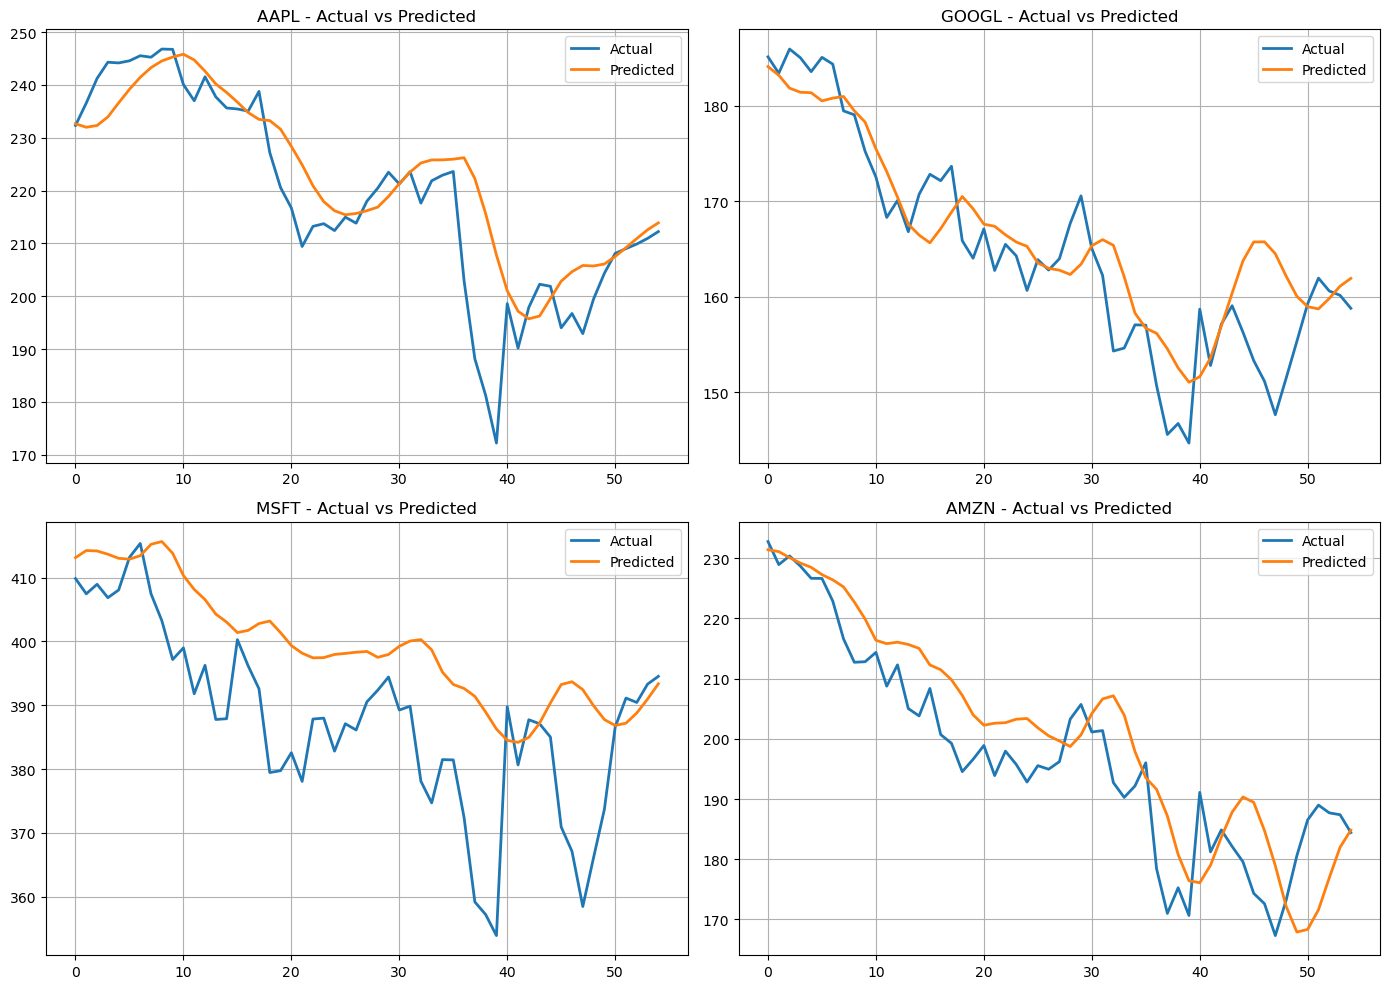

In [103]:
n = len(tickers_list)
cols = 2
rows = (n + 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axs = axs.flatten()

for i, ticker in enumerate(tickers_list):
    axs[i].plot(y_test_sets[ticker], label='Actual', linewidth=2)
    axs[i].plot(y_pred_sets[ticker], label='Predicted', linewidth=2)
    axs[i].set_title(f'{ticker} - Actual vs Predicted')
    axs[i].legend()
    axs[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [133]:
## Step 3 : Compute SHAP values (GradientExplainer)

shap_values_map = {}

def compute_shap(model, X_background, X_test):

    explainer = shap.GradientExplainer(model, X_background)
    shap_values = explainer.shap_values(X_test)
    return shap_values

for ticker in tickers_list:

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:100]  # Using first 100 samples for background, might want to be random instead
    X_test = X_test_sets[ticker]

    # Compute SHAP values
    print(f'\nComputing SHAP values for {ticker}...')
    shap_values = compute_shap(model, X_background, X_test) # Only computing for first 10 samples due to slowness of KernelExplainer
    shap_values_map[ticker] = shap_values

print("\nSHAP values computed.")


Computing SHAP values for AAPL...

Computing SHAP values for GOOGL...

Computing SHAP values for MSFT...

Computing SHAP values for AMZN...

SHAP values computed.


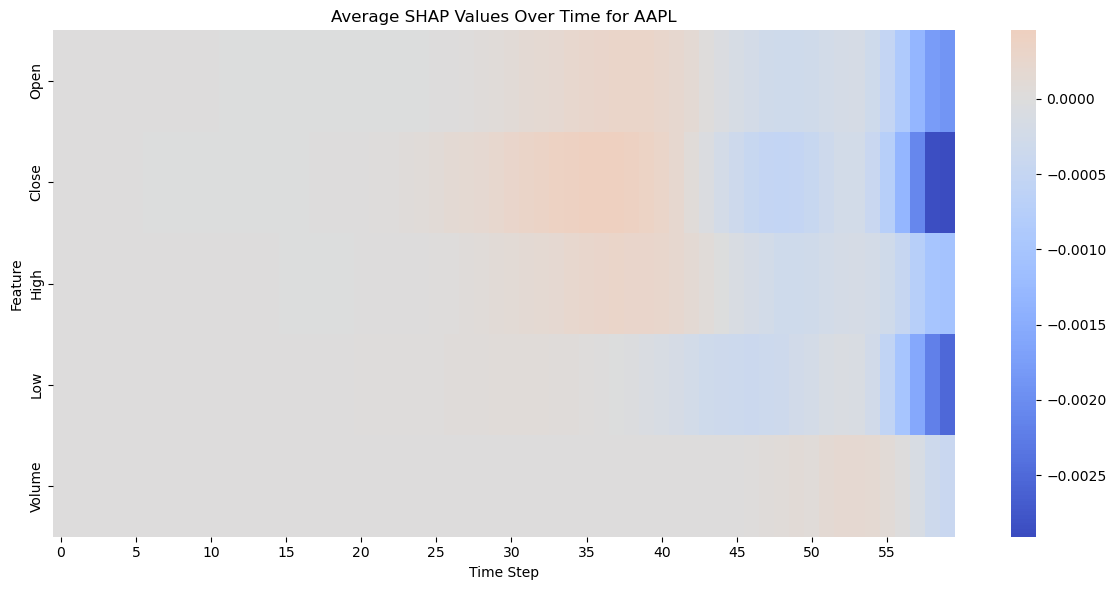

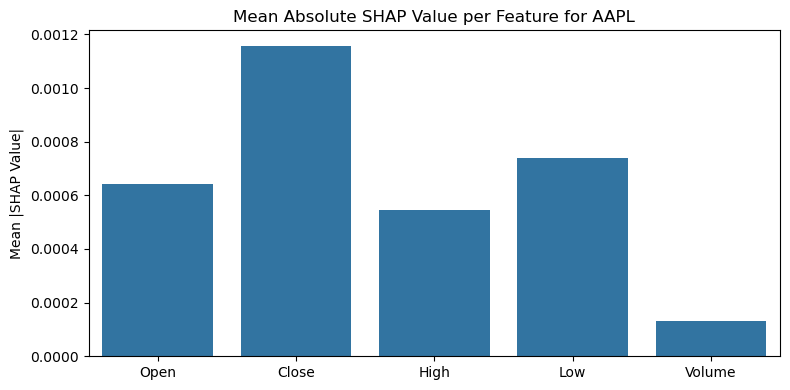

Top 3 features for AAPL: ['Close', 'Low', 'Open']


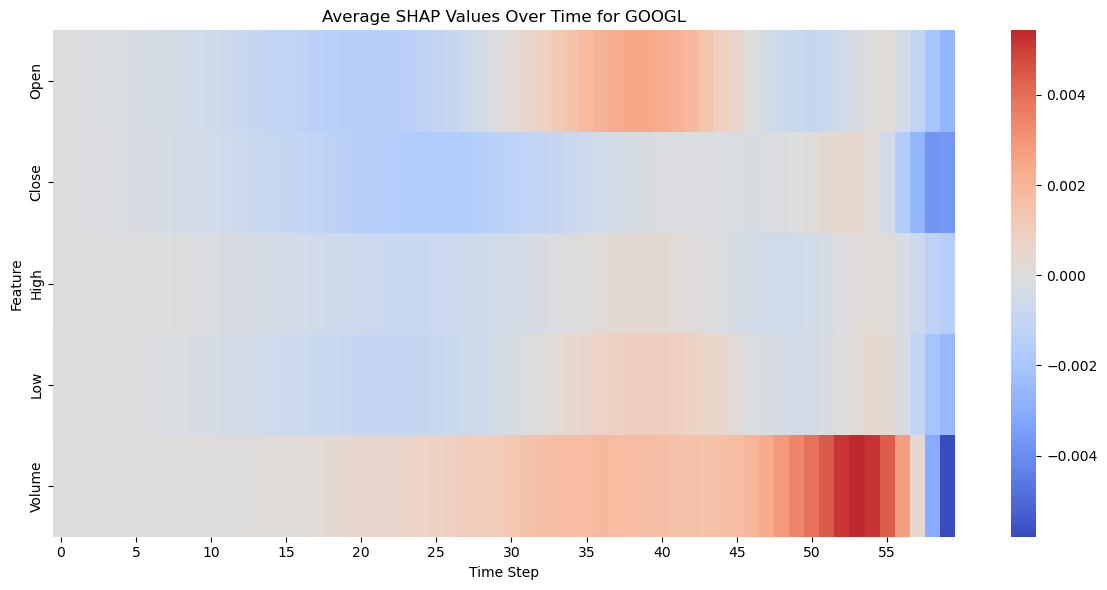

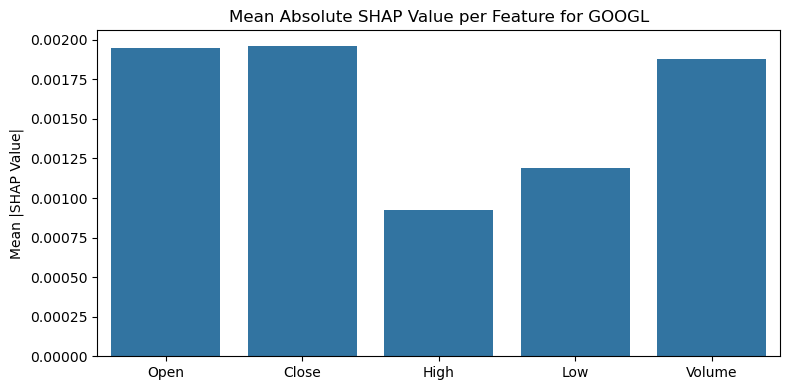

Top 3 features for GOOGL: ['Close', 'Open', 'Volume']


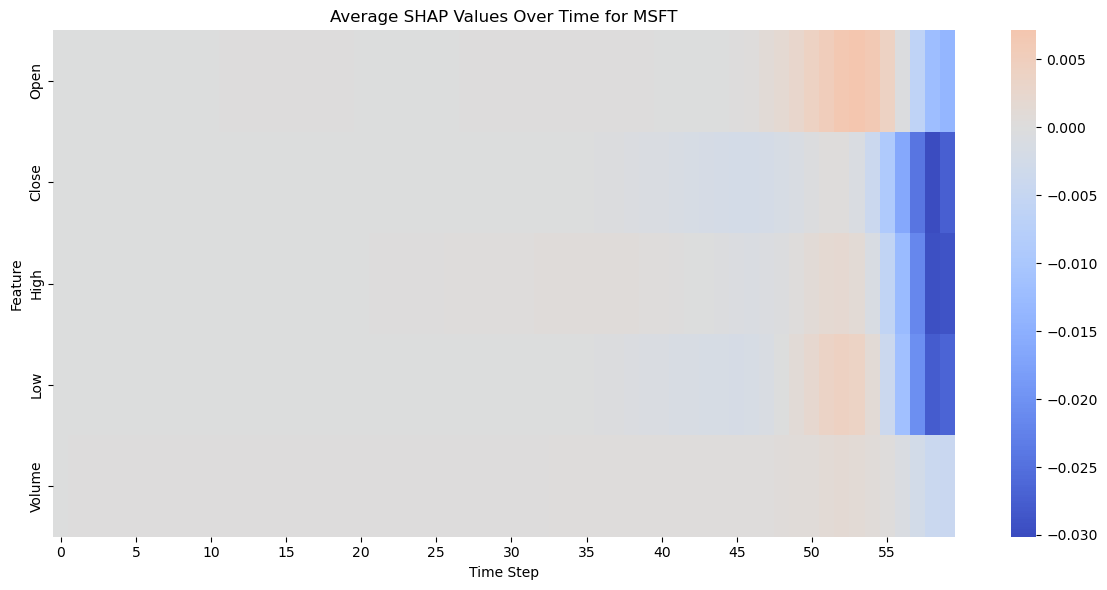

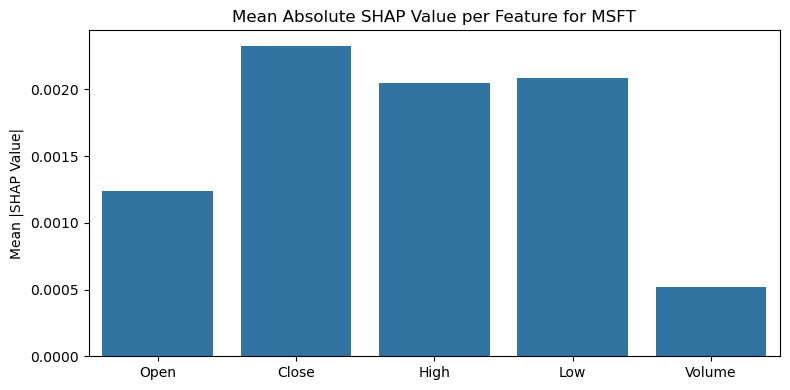

Top 3 features for MSFT: ['Close', 'Low', 'High']


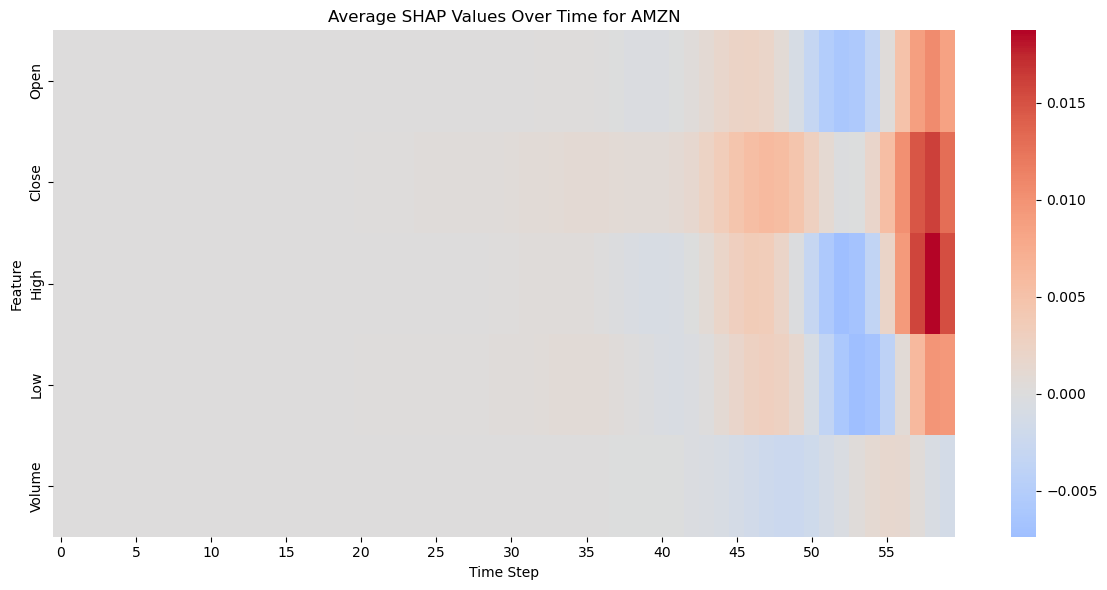

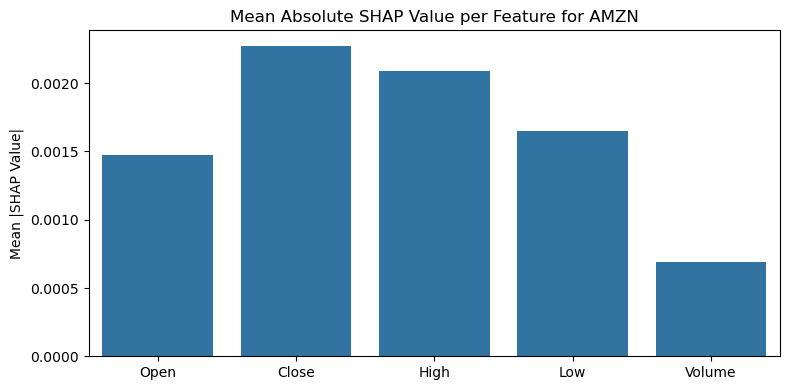

Top 3 features for AMZN: ['Close', 'High', 'Low']


In [ ]:
## Step 5 : Visualize SHAP values
shap.initjs()

SHAP_top3_features_per_ticker = {}

for ticker in tickers_list:

    # Load data
    X_test = X_test_sets[ticker]
    shap_values = shap_values_map[ticker]  # shape: (60, 5, 1)
    avg_shap_values = np.mean(shap_values, axis=0).squeeze(-1)  # shape: (60, 5, 1) -> (60, 5)
    avg_shap_transposed = avg_shap_values.T  # shape: (5, 60)
    abs_avg_shap_values = np.mean(np.abs(shap_values), axis=(0, 1)).squeeze(-1)  # shape: (5,)

    # --- Heatmap of average SHAP values over time ---
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        avg_shap_transposed,
        xticklabels=5,
        yticklabels=included_features,
        cmap='coolwarm',
        center=0,
        annot=False
    )
    plt.title(f'Average SHAP Values Over Time for {ticker}')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # --- Bar plot of total average impact per feature ---
    plt.figure(figsize=(8, 4))
    sns.barplot(x=included_features, y=abs_avg_shap_values)
    plt.title(f'Mean Absolute SHAP Value per Feature for {ticker}')
    plt.ylabel('Mean |SHAP Value|')
    plt.tight_layout()
    plt.show()

    # --- Top 3 features based on mean absolute SHAP values ---
    top3_idx = np.argsort(-abs_avg_shap_values)[:3]
    top3_features = [included_features[i] for i in top3_idx]
    SHAP_top3_features_per_ticker[ticker] = top3_features


In [106]:
## Step 4 : Compute WindowSHAP values
window_shap_values_map = {}
avg_window_shap_values_map = {}

def compute_window_shap(model, X_background, X_test, window_size = 10):
    explainer = StationaryWindowSHAP(model, window_len=window_size, B_ts=X_background, test_ts=X_test, model_type='lstm')
    window_shap_values = explainer.shap_values()
    return window_shap_values

for ticker in tickers_list:

    print(f'Computing WindowSHAP values for {ticker}...')

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:10]  # Using first 10 samples for background, might want to be random instead and 100 instead
    X_test = X_test_sets[ticker]

    ticker_windowSHAP_values = np.zeros((len(X_test), X_test.shape[1], X_test.shape[2]))

    for i in tqdm(range(len(X_test)), desc=f'Observation {i} of {len(X_test)}'):
        window_shap_values = compute_window_shap(model, X_background, X_test[i:i+1])
        ticker_windowSHAP_values[i,:,:] = window_shap_values

    avg_window_shap = np.mean(np.abs(ticker_windowSHAP_values), axis=0)  # shape: (window_size, features)

    window_shap_values_map[ticker] = ticker_windowSHAP_values
    avg_window_shap_values_map[ticker] = avg_window_shap

print("\nWindowSHAP values computed.")

Computing WindowSHAP values for AAPL...


Observation 3 of 55: 100%|██████████| 55/55 [11:00<00:00, 12.00s/it]


Computing WindowSHAP values for GOOGL...


Observation 54 of 55:  24%|██▎       | 13/55 [02:49<09:08, 13.06s/it]


KeyboardInterrupt: 

WindowSHAP heatmap of average values over time


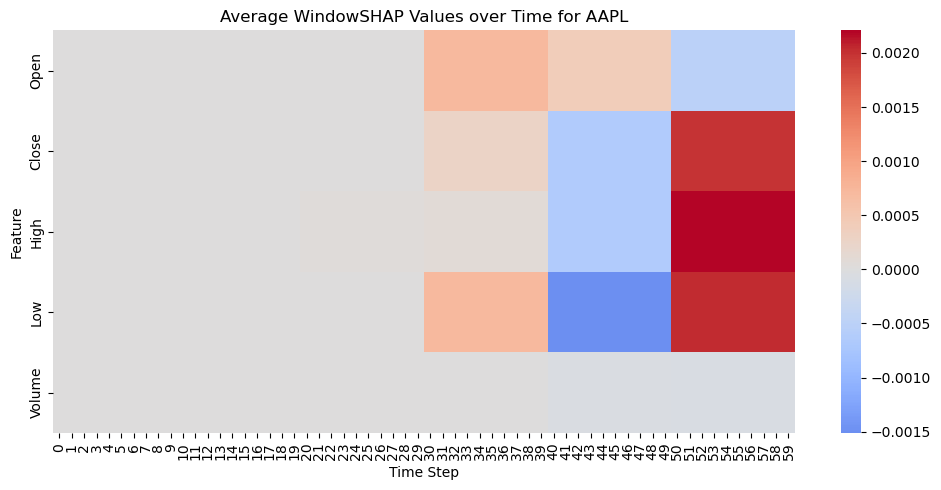

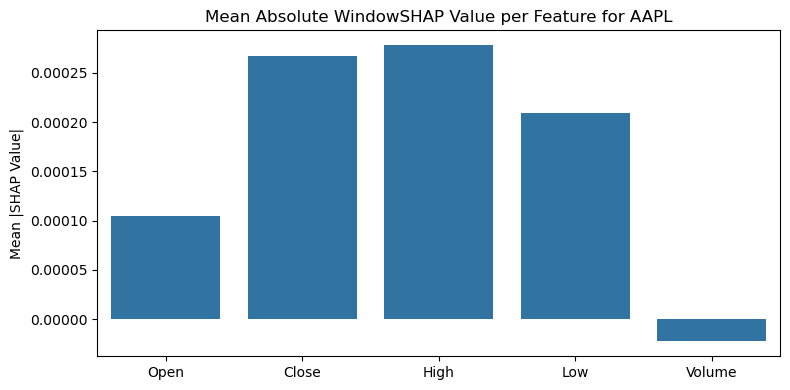

WindowSHAP heatmap of average values over time


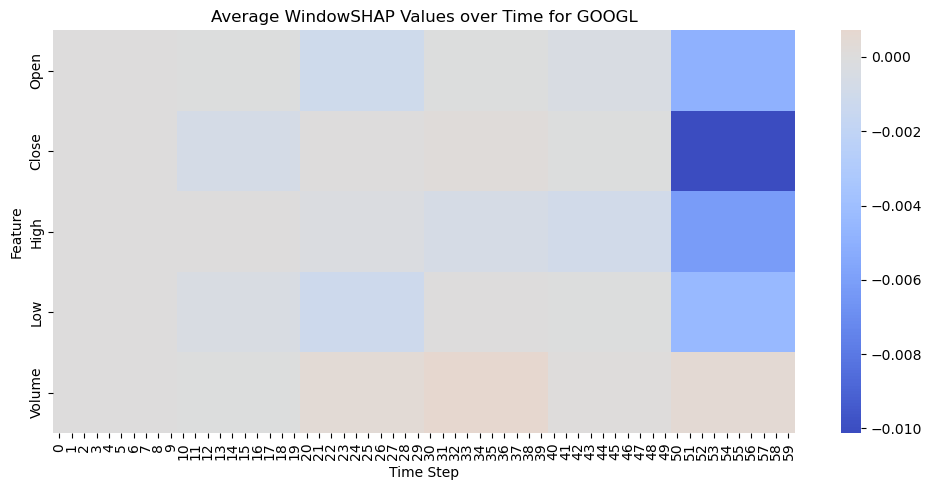

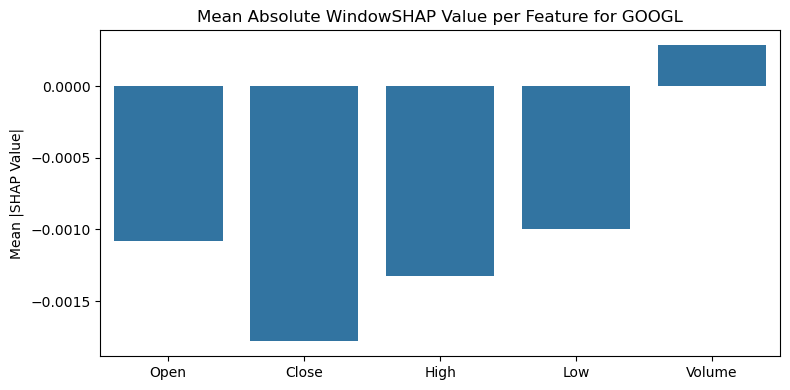

WindowSHAP heatmap of average values over time


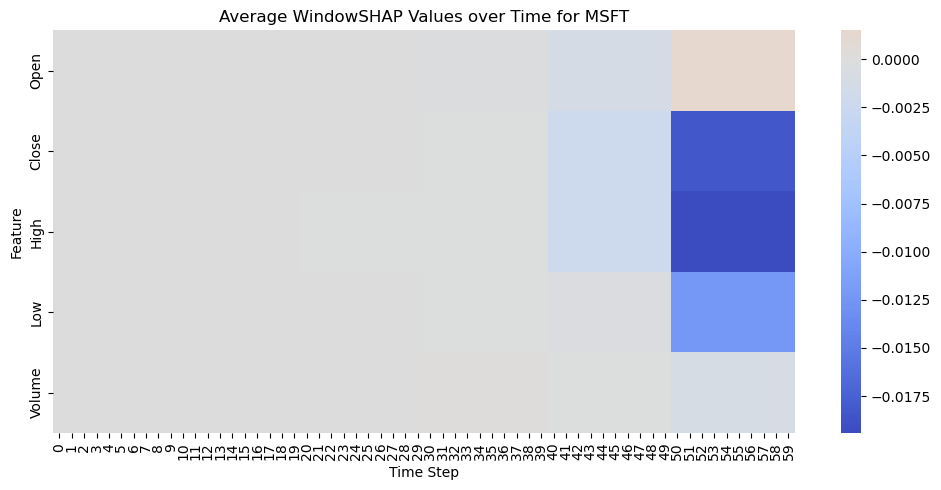

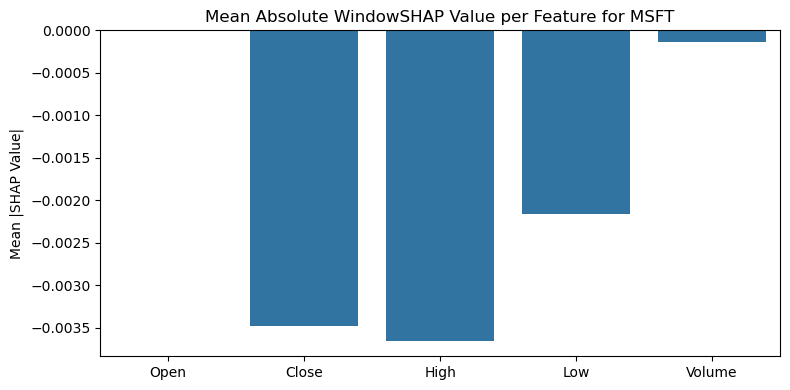

WindowSHAP heatmap of average values over time


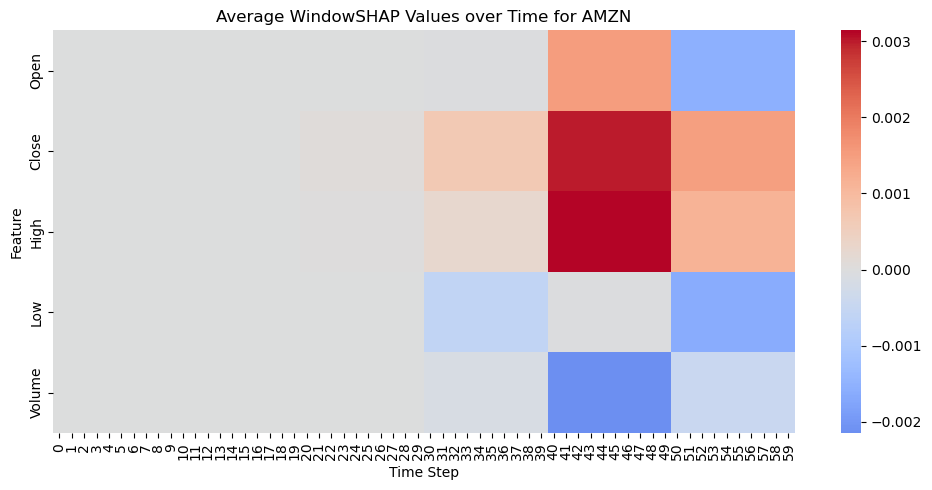

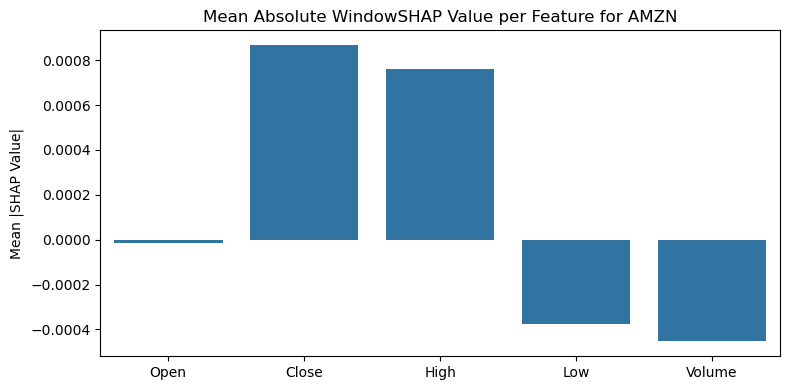

In [ ]:
## Step 6 : Visualize WindowSHAP values
shap.initjs()

for ticker in tickers_list:

    # Load data
    X_test = X_test_sets[ticker]
    avg_window_shap_values = avg_window_shap_values_map[ticker]  # shape: (timesteps, features)
    feature_names = included_features

    # === Heatmap of Average WindowSHAP over Time ===
    print("WindowSHAP heatmap of average values over time")

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        avg_window_shap_values.T,  # shape: (features, timesteps)
        xticklabels=True,
        yticklabels=feature_names,
        cmap='coolwarm',
        center=0
    )
    plt.title(f'Average WindowSHAP Values over Time for {ticker}')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # === Bar Plot of Average WindowSHAP over Time ===
    mean_importance = np.mean(np.abs(avg_window_shap_values), axis=0)  # shape: (5,)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=included_features, y=mean_importance)
    plt.title(f'Mean Absolute WindowSHAP Value per Feature for {ticker}')
    plt.ylabel('Mean |SHAP Value|')
    plt.tight_layout()
    plt.show()


In [ ]:
# Step 7 : Compute feature-based WindowSHAP

from statsmodels.tsa.seasonal import seasonal_decompose

trend_window_shap_values_map = {}
season_window_shap_values_map = {}
resid_window_shap_values_map = {}

avg_trend_window_shap_values_map = {}
avg_season_window_shap_values_map = {}
avg_resid_window_shap_values_map = {}

# --- 1. Decompose each feature in each sample ---

def decompose_series(ts, period=12):
    result = seasonal_decompose(ts, model='additive', period=period, extrapolate_trend='freq')
    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid
    return trend, seasonal, resid

def decompose_dataset(X, period=12):
    n_samples, n_timesteps, n_features = X.shape
    trend_data = np.zeros_like(X)
    seasonal_data = np.zeros_like(X)
    resid_data = np.zeros_like(X)

    for i in range(n_samples):
        for j in range(n_features):
            ts = pd.Series(X[i, :, j])
            trend, seasonal, resid = decompose_series(ts, period)
            trend_data[i, :, j] = trend
            seasonal_data[i, :, j] = seasonal
            resid_data[i, :, j] = resid
    
    return trend_data, seasonal_data, resid_data

for ticker in tickers_list:
    print(f"\nProcessing ticker {ticker}...")

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_test = X_test_sets[ticker]

    # Decompose train and test data
    trend_train, seasonal_train, resid_train = decompose_dataset(X_train)
    trend_test, seasonal_test, resid_test = decompose_dataset(X_test)

    background_size = min(10, len(trend_train))  # you can adjust this based on performance

    # Downsample if needed, like in your WindowSHAP example
    # Example: every 3rd timestep (adjust as you see fit)
    trend_train_ds = trend_train[:background_size, :, :]
    trend_test_ds = trend_test[:background_size, :, :]

    seasonal_train_ds = seasonal_train[:background_size, :, :]
    seasonal_test_ds = seasonal_test[:background_size, :, :]

    resid_train_ds = resid_train[:background_size, :, :]
    resid_test_ds = resid_test[:background_size, :, :]

    # Window size per your choice, could also vary per component
    window_size = 10

    # Compute WindowSHAP for trend
    print(f"Computing WindowSHAP for trend component of {ticker}...")
    trend_window_shap_values = np.zeros((len(trend_test_ds), trend_test_ds.shape[1], trend_test_ds.shape[2]))
    for i in tqdm(range(len(trend_test_ds)), desc=f'WindowSHAP - Trend - {ticker}'):
        shap_vals = compute_window_shap(model, trend_train_ds, trend_test_ds[i:i+1], window_size=window_size)
        trend_window_shap_values[i, :, :] = shap_vals

    # Compute WindowSHAP for seasonal
    print(f"Computing WindowSHAP for seasonal component of {ticker}...")
    seasonal_window_shap_values = np.zeros((len(seasonal_test_ds), seasonal_test_ds.shape[1], seasonal_test_ds.shape[2]))
    for i in tqdm(range(len(seasonal_test_ds)), desc=f'WindowSHAP - Seasonal - {ticker}'):
        shap_vals = compute_window_shap(model, seasonal_train_ds, seasonal_test_ds[i:i+1], window_size=window_size)
        seasonal_window_shap_values[i, :, :] = shap_vals

    # Compute WindowSHAP for residual
    print(f"Computing WindowSHAP for residual component of {ticker}...")
    resid_window_shap_values = np.zeros((len(resid_test_ds), resid_test_ds.shape[1], resid_test_ds.shape[2]))
    for i in tqdm(range(len(resid_test_ds)), desc=f'WindowSHAP - Residual - {ticker}'):
        shap_vals = compute_window_shap(model, resid_train_ds, resid_test_ds[i:i+1], window_size=window_size)
        resid_window_shap_values[i, :, :] = shap_vals

    # Store results in your dictionary
    trend_window_shap_values_map[ticker] = trend_window_shap_values
    season_window_shap_values_map[ticker] = seasonal_window_shap_values
    resid_window_shap_values_map[ticker] = resid_window_shap_values
    
    avg_trend_window_shap_values_map[ticker] = np.mean(np.abs(trend_window_shap_values), axis=0)  # shape: (timesteps, features)
    avg_season_window_shap_values_map[ticker] = np.mean(np.abs(seasonal_window_shap_values), axis=0)
    avg_resid_window_shap_values_map[ticker] = np.mean(np.abs(resid_window_shap_values), axis=0)

    print(f"WindowSHAP computation done for {ticker}.")


Processing ticker AAPL...
Computing WindowSHAP for trend component of AAPL...


WindowSHAP - Trend - AAPL: 100%|██████████| 10/10 [01:57<00:00, 11.78s/it]


Computing WindowSHAP for seasonal component of AAPL...


WindowSHAP - Seasonal - AAPL: 100%|██████████| 10/10 [01:58<00:00, 11.81s/it]


Computing WindowSHAP for residual component of AAPL...


WindowSHAP - Residual - AAPL: 100%|██████████| 10/10 [01:59<00:00, 11.99s/it]


WindowSHAP computation done for AAPL.

Processing ticker GOOGL...
Computing WindowSHAP for trend component of GOOGL...


WindowSHAP - Trend - GOOGL: 100%|██████████| 10/10 [01:57<00:00, 11.79s/it]


Computing WindowSHAP for seasonal component of GOOGL...


WindowSHAP - Seasonal - GOOGL: 100%|██████████| 10/10 [01:57<00:00, 11.80s/it]


Computing WindowSHAP for residual component of GOOGL...


WindowSHAP - Residual - GOOGL: 100%|██████████| 10/10 [01:57<00:00, 11.77s/it]


WindowSHAP computation done for GOOGL.

Processing ticker MSFT...
Computing WindowSHAP for trend component of MSFT...


WindowSHAP - Trend - MSFT: 100%|██████████| 10/10 [01:58<00:00, 11.85s/it]


Computing WindowSHAP for seasonal component of MSFT...


WindowSHAP - Seasonal - MSFT: 100%|██████████| 10/10 [01:58<00:00, 11.80s/it]


Computing WindowSHAP for residual component of MSFT...


WindowSHAP - Residual - MSFT: 100%|██████████| 10/10 [01:57<00:00, 11.77s/it]


WindowSHAP computation done for MSFT.

Processing ticker AMZN...
Computing WindowSHAP for trend component of AMZN...


WindowSHAP - Trend - AMZN: 100%|██████████| 10/10 [01:57<00:00, 11.77s/it]


Computing WindowSHAP for seasonal component of AMZN...


WindowSHAP - Seasonal - AMZN: 100%|██████████| 10/10 [07:51<00:00, 47.18s/it]


Computing WindowSHAP for residual component of AMZN...


WindowSHAP - Residual - AMZN: 100%|██████████| 10/10 [01:58<00:00, 11.83s/it]

WindowSHAP computation done for AMZN.



Ticker: AAPL
Average WindowSHAP heatmaps over time for AAPL


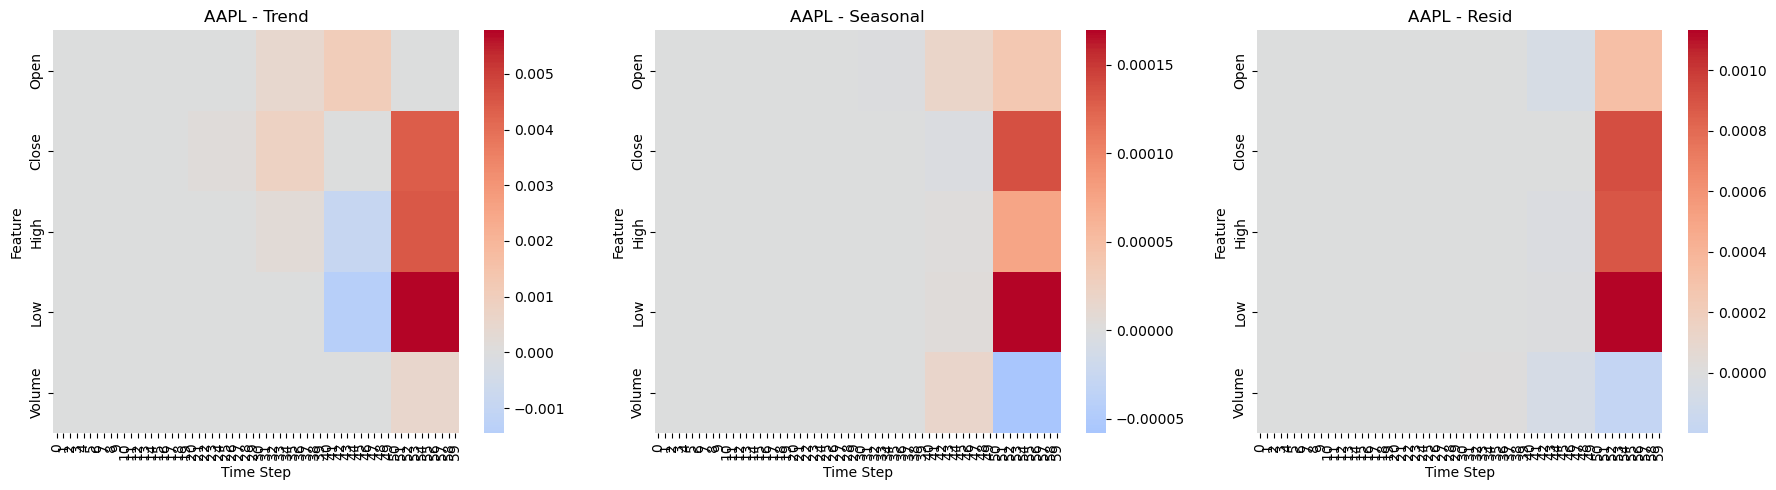


Ticker: GOOGL
Average WindowSHAP heatmaps over time for GOOGL


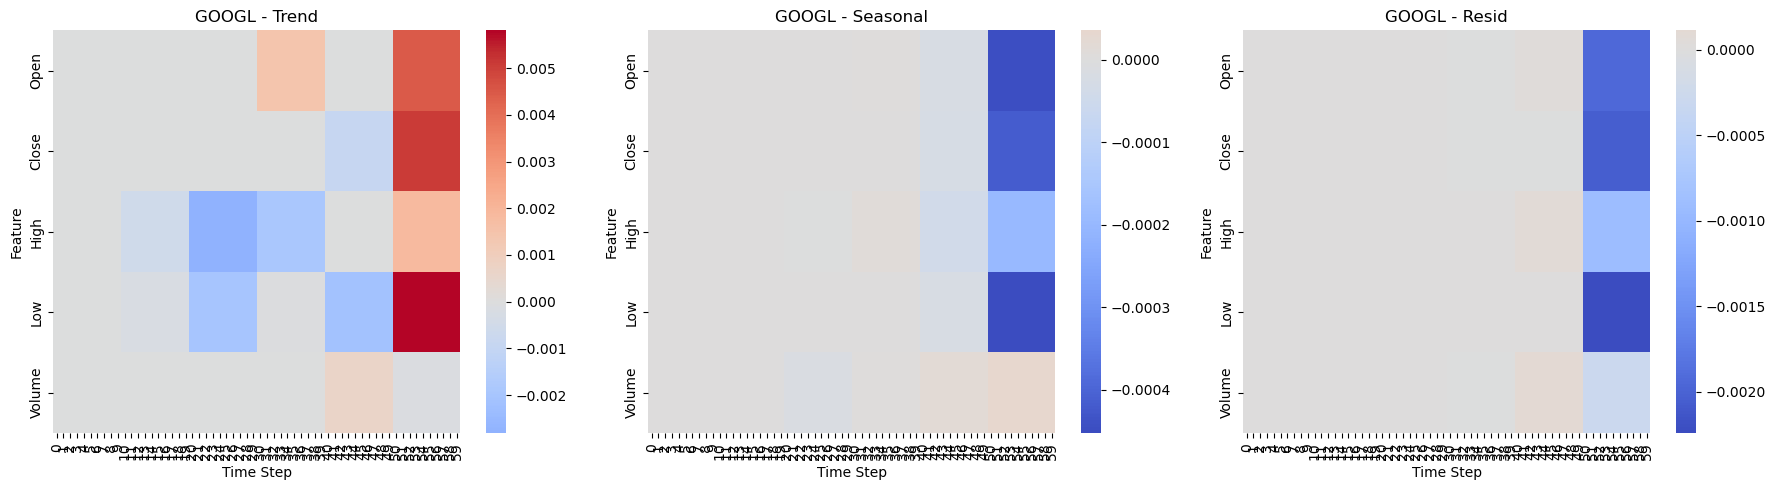


Ticker: MSFT
Average WindowSHAP heatmaps over time for MSFT


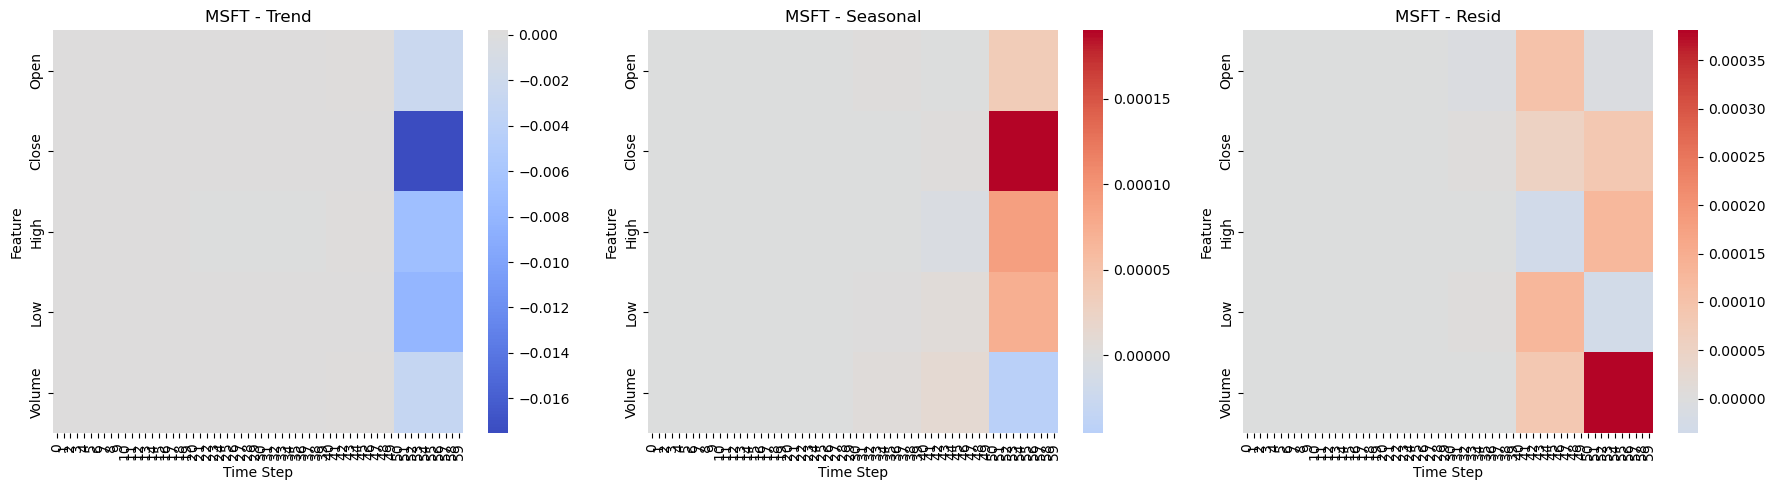


Ticker: AMZN
Average WindowSHAP heatmaps over time for AMZN


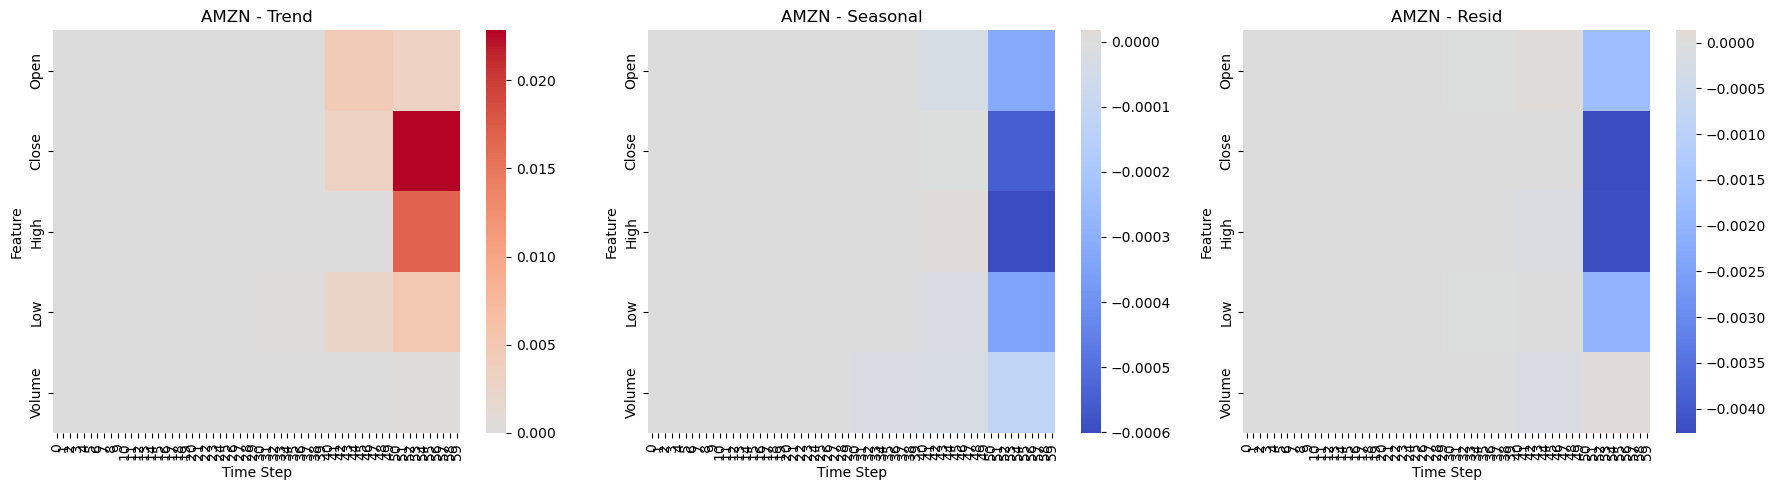

In [ ]:
## Step 8 : Visualize decomposed WindowSHAP values

shap.initjs()

components = ['trend', 'seasonal', 'resid']
timestep_labels = True  # Turn off if too many time steps

for ticker in tickers_list:
    print(f"\nTicker: {ticker}")
    feature_names = included_features
    X_test = X_test_sets[ticker]  # Optional: X_test = X_test[:, ::3, :]

    # Load SHAP values
    trend_shap = avg_trend_window_shap_values_map[ticker]
    seasonal_shap = avg_season_window_shap_values_map[ticker]
    resid_shap = avg_resid_window_shap_values_map[ticker]

    shap_values_dict = {
        'trend': trend_shap,
        'seasonal': seasonal_shap,
        'resid': resid_shap
    }

    # --- Plot heatmaps for single sample ---
    print(f"Average WindowSHAP heatmaps over time for {ticker}")
    fig, axes = plt.subplots(1, len(components), figsize=(18, 5))

    for i, comp in enumerate(components):
        comp_shap = shap_values_dict[comp]
        sns.heatmap(
            comp_shap.T,  # shape: (features, timesteps)
            xticklabels=timestep_labels,
            yticklabels=feature_names,
            cmap='coolwarm',
            center=0,
            ax=axes[i]
        )
        axes[i].set_title(f"{ticker} - {comp.capitalize()}")
        axes[i].set_xlabel("Time Step")
        axes[i].set_ylabel("Feature")

    plt.tight_layout()
    plt.show()

In [ ]:
from numpy import percentile

def eval_perturbation(model, X_test, y_pred, y_test, percentiles, shap_values, is_windowshap=True, mask_value=0):
    num_samples, num_timesteps, num_features = X_test.shape
    losses = []

    og_loss = np.mean((y_pred - y_test) ** 2)

    for p in percentiles:
        perturbed_X = X_test.copy()

        for i in range(num_samples):
            if is_windowshap:
                # SHAP shape: (timesteps, features)
                shap_importance = np.abs(shap_values[i]).sum(axis=1)
                top_timesteps = np.argsort(shap_importance)[-int(num_timesteps * p / 100):]
                perturbed_X[i, top_timesteps, :] = mask_value

            else:
                # SHAP shape: (features,)
                shap_importance = np.abs(shap_values[i])
                top_features = np.argsort(shap_importance)[-int(num_features * p / 100):]
                perturbed_X[i, :, top_features] = mask_value

        perturbed_pred = model.predict(perturbed_X, verbose=0)
        perturbed_loss = np.mean((perturbed_pred - y_test) ** 2)

        delta_mse = perturbed_loss - og_loss  # 🔁 Replaces percent change
        losses.append(delta_mse)

    return np.array(losses)


percentiles = np.arange(60, 91)
methods = ['SHAP', 'WindowSHAP', 'Decomposed WindowSHAP']
shap_results = {}
window_shap_results = {}
decomp_shap_results = {}

N = min(
    X_test.shape[0],
    shap_values_map[ticker].shape[0],
    window_shap_values_map[ticker].shape[0],
    trend_window_shap_values_map[ticker].shape[0],
    season_window_shap_values_map[ticker].shape[0],
    resid_window_shap_values_map[ticker].shape[0]
)


for ticker in tickers_list:
    print(f"\nEvaluating perturbation for {ticker}...")
    model = models[ticker]
    X_test = X_test_sets[ticker]
    y_pred = y_pred_sets[ticker]
    y_test = y_test_sets[ticker]

    # Use consistent slices
    X_test_sub = X_test[:N]
    y_pred_sub = y_pred[:N]
    y_test_sub = y_test[:N]

    # SHAP
    shap_values = np.squeeze(shap_values_map[ticker], axis=-1)[:N]
    shap_results[ticker] = eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, shap_values, is_windowshap=True)

    # WindowSHAP
    window_shap_values = window_shap_values_map[ticker][:N]
    window_shap_results[ticker] = eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, window_shap_values, is_windowshap=True)

    # Decomposed WindowSHAP
    trend_shap = trend_window_shap_values_map[ticker][:N]
    seasonal_shap = season_window_shap_values_map[ticker][:N]
    resid_shap = resid_window_shap_values_map[ticker][:N]
    decomp_shap_results[ticker] = {
        'trend': eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, trend_shap, is_windowshap=True),
        'seasonal': eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, seasonal_shap, is_windowshap=True),
        'resid': eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, resid_shap, is_windowshap=True)
    }

    
    


Evaluating perturbation for AAPL...

Evaluating perturbation for GOOGL...

Evaluating perturbation for MSFT...

Evaluating perturbation for AMZN...


Plotting perturbation analysis for AAPL...


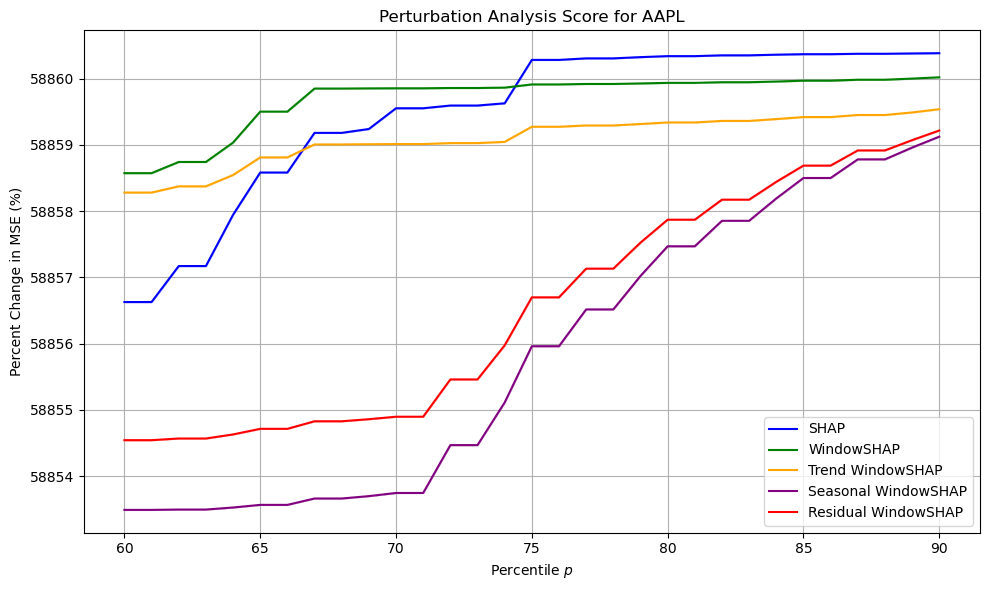

Plotting perturbation analysis for GOOGL...


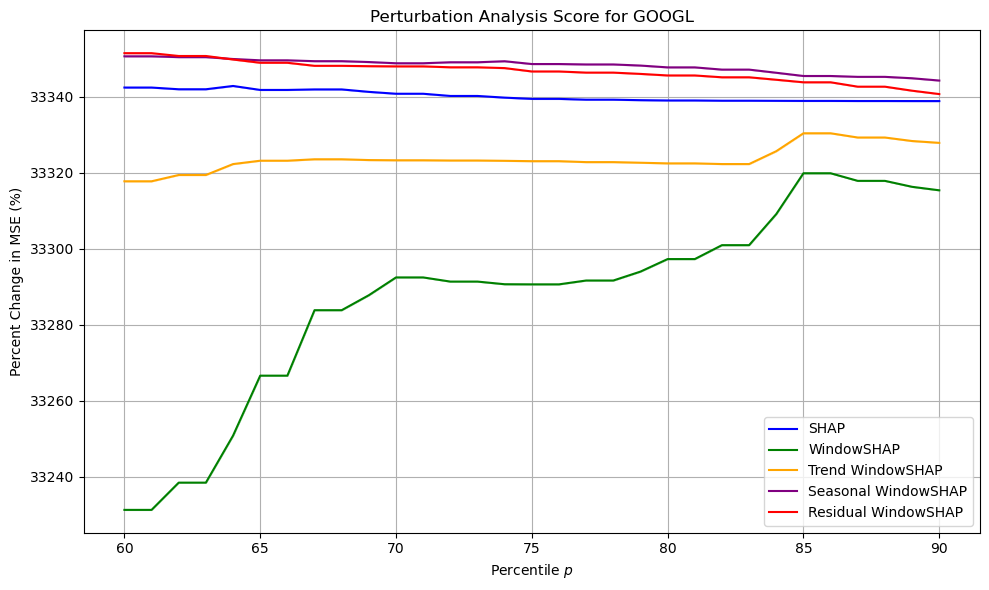

Plotting perturbation analysis for MSFT...


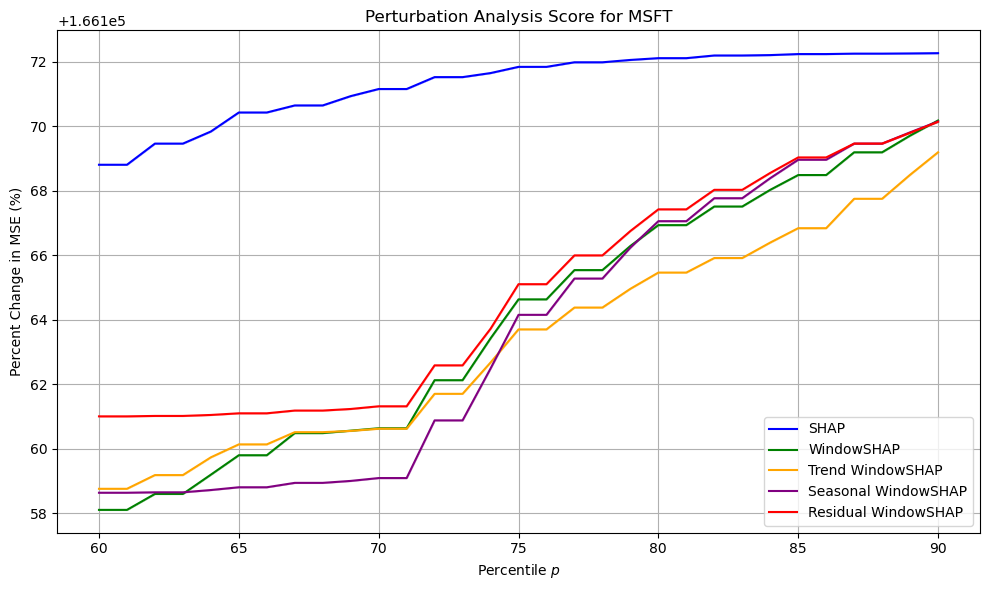

Plotting perturbation analysis for AMZN...


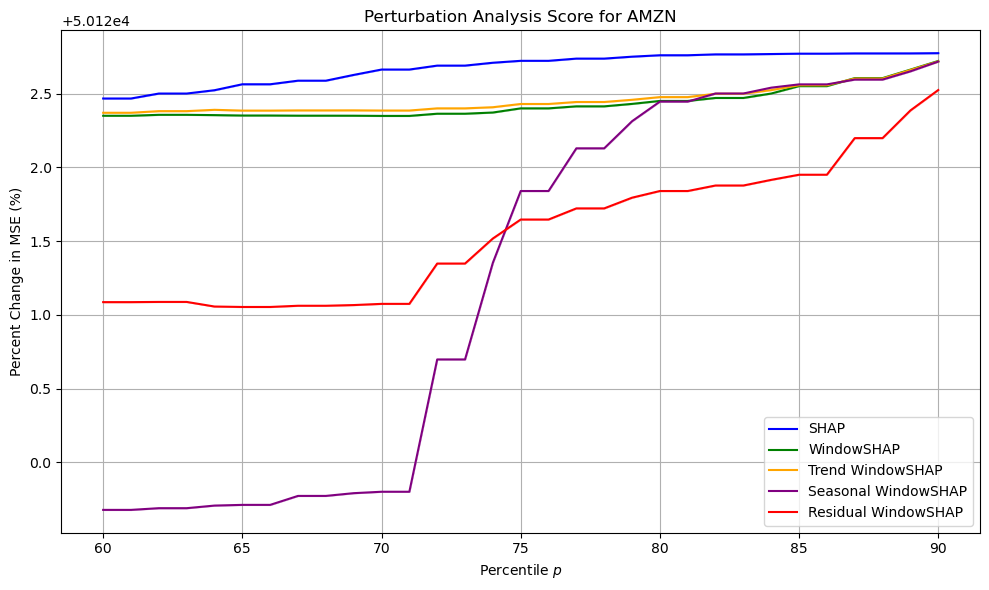

In [ ]:
def plot_perturbation_analysis(percentiles, shap_results, window_shap_results, decomp_shap_results, ticker, colors=None):
    plt.figure(figsize=(10, 6))

    def get_ticker_mean_std(results):
        scores = np.array(results)

        if scores.ndim == 0:
            raise ValueError("Input results are scalar. Expected array-like shape (num_runs, num_percentiles).")
        elif scores.ndim == 1:
            if len(scores) == len(percentiles):
                # Single run, already shaped correctly
                scores = scores[np.newaxis, :]
            else:
                raise ValueError(f"1D input length ({len(scores)}) does not match number of percentiles ({len(percentiles)}).")

        elif scores.ndim > 2:
            raise ValueError(f"Too many dimensions in scores: shape {scores.shape}")

        mean = np.mean(scores, axis=0)
        std = np.std(scores, axis=0)
        return mean, std

    
    if colors is None:
        colors = ['blue', 'green', 'orange', 'purple', 'red']

    # Plotting logic — moved outside of the colors conditional
    shap_mean, shap_std = get_ticker_mean_std(shap_results[ticker])
    win_mean, win_std = get_ticker_mean_std(window_shap_results[ticker])
    trend_mean, trend_std = get_ticker_mean_std(decomp_shap_results[ticker]['trend'])
    season_mean, season_std = get_ticker_mean_std(decomp_shap_results[ticker]['seasonal'])
    resid_mean, resid_std = get_ticker_mean_std(decomp_shap_results[ticker]['resid'])

    plt.plot(percentiles, shap_mean, label='SHAP', color=colors[0])
    plt.fill_between(percentiles, shap_mean - shap_std, shap_mean + shap_std, color=colors[0], alpha=0.2)

    plt.plot(percentiles, win_mean, label='WindowSHAP', color=colors[1])
    plt.fill_between(percentiles, win_mean - win_std, win_mean + win_std, color=colors[1], alpha=0.2)

    plt.plot(percentiles, trend_mean, label='Trend WindowSHAP', color=colors[2])
    plt.fill_between(percentiles, trend_mean - trend_std, trend_mean + trend_std, color=colors[2], alpha=0.2)

    plt.plot(percentiles, season_mean, label='Seasonal WindowSHAP', color=colors[3])
    plt.fill_between(percentiles, season_mean - season_std, season_mean + season_std, color=colors[3], alpha=0.2)

    plt.plot(percentiles, resid_mean, label='Residual WindowSHAP', color=colors[4])
    plt.fill_between(percentiles, resid_mean - resid_std, resid_mean + resid_std, color=colors[4], alpha=0.2)

    plt.title(f"Perturbation Analysis Score for {ticker}")
    plt.xlabel("Percentile $p$")
    plt.ylabel("Percent Change in MSE (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for ticker in tickers_list:
    print(f"Plotting perturbation analysis for {ticker}...")
    plot_perturbation_analysis(
        percentiles,
        shap_results,
        window_shap_results,
        decomp_shap_results,
        ticker=ticker
    )
